In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.gridspec as gridspec
import textwrap
import os
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import numpy as np
import seaborn as sns
column_time = 'TimeIndice'
time_series_columns = ['HeartRate', 'VelocityX', 'VelocityY', 'VelocityZ', 'RotationX', 'RotationY', 'RotationZ']



def load_data(file_path, column_time):
    df = pd.read_csv(file_path)
    
    # Remove rows where TimeIndice is NaN
    df = df[df[column_time].notna()]
    
    # Convert all string columns to lowercase
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    
    return df

def extract_timestamps(df, column_time, record_index):
    series_time = df[column_time].iloc[record_index]
    timestamps = [datetime.strptime(x.strip(), '%H:%M:%S.%f') for x in series_time.split(';') if x.strip()]
    
    return timestamps

def plot_data(df, timestamps, columns, record_index):
    n = len(columns)
    n_rows = (n + 1) // 2
    
    gs = gridspec.GridSpec(n_rows + 1, 2, height_ratios=[0.1] + [1]*n_rows)
    fig = plt.figure(figsize=(20, 2.5 * (n_rows + 1)))
    
    ax_text = fig.add_subplot(gs[0, :])
    ax_text.axis('off')
    
    all_columns = set(df.columns)
    plottable_columns = set(columns + [column_time])
    info_columns = list(all_columns - plottable_columns)
    
    if info_columns:
        info_text = "\t\t".join([f"{col}: {df[col].iloc[record_index]}" for col in info_columns])
        wrapped_text = textwrap.fill(info_text, width=220)
        ax_text.text(0, 0.5, wrapped_text, ha='left', va='center', fontsize=13)
    
    axs = [fig.add_subplot(gs[i+1, j]) for i in range(n_rows) for j in range(2)]
    
    for idx, ax in enumerate(axs[:n]):
        column = columns[idx]
        series_data = df[column].iloc[record_index]
        data_values = [float(x.strip()) for x in series_data.split(';') if x.strip()]

        ax.plot(timestamps, data_values, label=column)
        ax.set_title(column)
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Data Values')
        ax.grid(True)
        ax.legend()
        
    if n % 2 != 0:
        axs[-1].axis('off')
        
    plt.tight_layout()
    plt.show()

def plot_smooth_data(df, timestamps, columns, record_index, smoothness):
    n = len(columns)
    n_rows = (n + 1) // 2
    
    gs = gridspec.GridSpec(n_rows + 1, 2, height_ratios=[0.1] + [1]*n_rows)
    fig = plt.figure(figsize=(20, 2.5 * (n_rows + 1)))
    
    ax_text = fig.add_subplot(gs[0, :])
    ax_text.axis('off')
    
    all_columns = set(df.columns)
    plottable_columns = set(columns + [column_time])
    info_columns = list(all_columns - plottable_columns)
    
    if info_columns:
        info_text = "\t\t".join([f"{col}: {df[col].iloc[record_index]}" for col in info_columns])
        wrapped_text = textwrap.fill(info_text, width=220)
        ax_text.text(0, 0.5, wrapped_text, ha='left', va='center', fontsize=13)
    
    axs = [fig.add_subplot(gs[i+1, j]) for i in range(n_rows) for j in range(2)]
    
    for idx, ax in enumerate(axs[:n]):
        column = columns[idx]
        series_data = df[column].iloc[record_index]
        data_values = [float(x.strip()) for x in series_data.split(';') if x.strip()]

        # Create a cubic spline interpolation of the data
        spline = UnivariateSpline(range(len(data_values)), data_values, s=smoothness)
        x_new = np.linspace(0, len(data_values) - 1, 1000)
        y_new = spline(x_new)

        ax.plot(x_new, y_new, label=column)
        ax.set_title(column)
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Data Values')
        ax.grid(True)
        ax.legend()
        
    if n % 2 != 0:
        axs[-1].axis('off')
        
    plt.tight_layout()
    plt.show()

def delete_record_and_save_to_csv(df, record_index, csv_filename):
    df = df.drop(index=record_index)
    df.to_csv(csv_filename, index=False)
    df.loc[:,['Set', 'Name', 'Exercise Selected', 'Load', 'Reps', 'RPE', 'Remarks', 'Duration', 'Id']]

# Get a list of CSV files in the current directory
csv_files = [file for file in os.listdir('./') if file.endswith('.csv')]

# Initialize an empty dataframe to store concatenated data
all_data = pd.DataFrame()

# Iterate over CSV files and concatenate them
for file_path in csv_files:
    df = load_data(file_path, column_time)
    all_data = pd.concat([all_data, df], ignore_index=True)

# Remove duplicates based on all columns except "Id"
all_data = all_data.drop_duplicates(subset=all_data.columns.difference(['Id']))

# Sort the concatenated dataframe based on the "Id" column
all_data['Id'] = pd.to_datetime(all_data['Id'])
all_data = all_data.sort_values(by='Id')

# Reset the index after sorting
all_data = all_data.reset_index(drop=True)

all_data.to_csv('all_data.csv', index=False)


In [23]:
record_index = 319

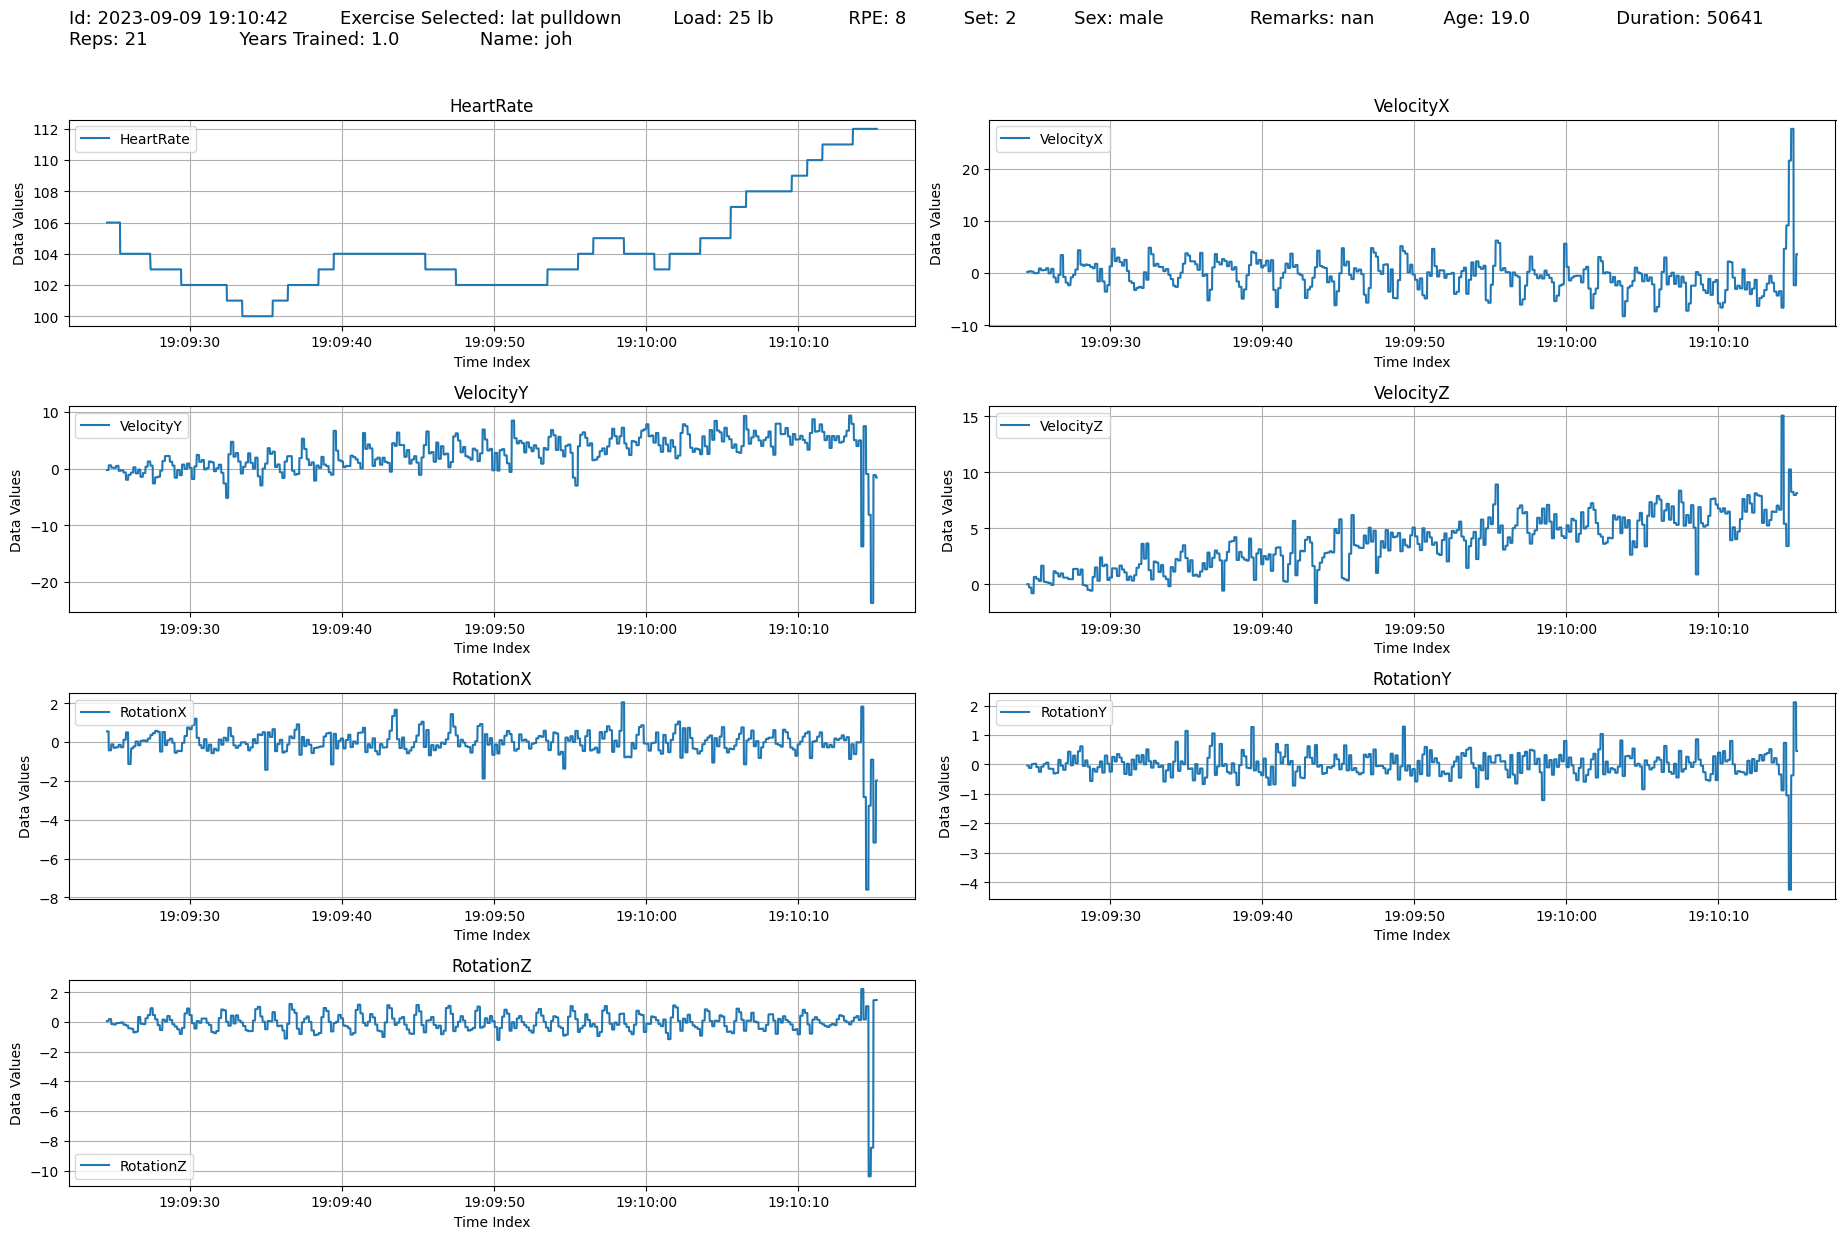

In [24]:
# Extract timestamps and plot the data
timestamps = extract_timestamps(all_data, column_time, record_index)
plot_data(all_data, timestamps, time_series_columns, record_index)



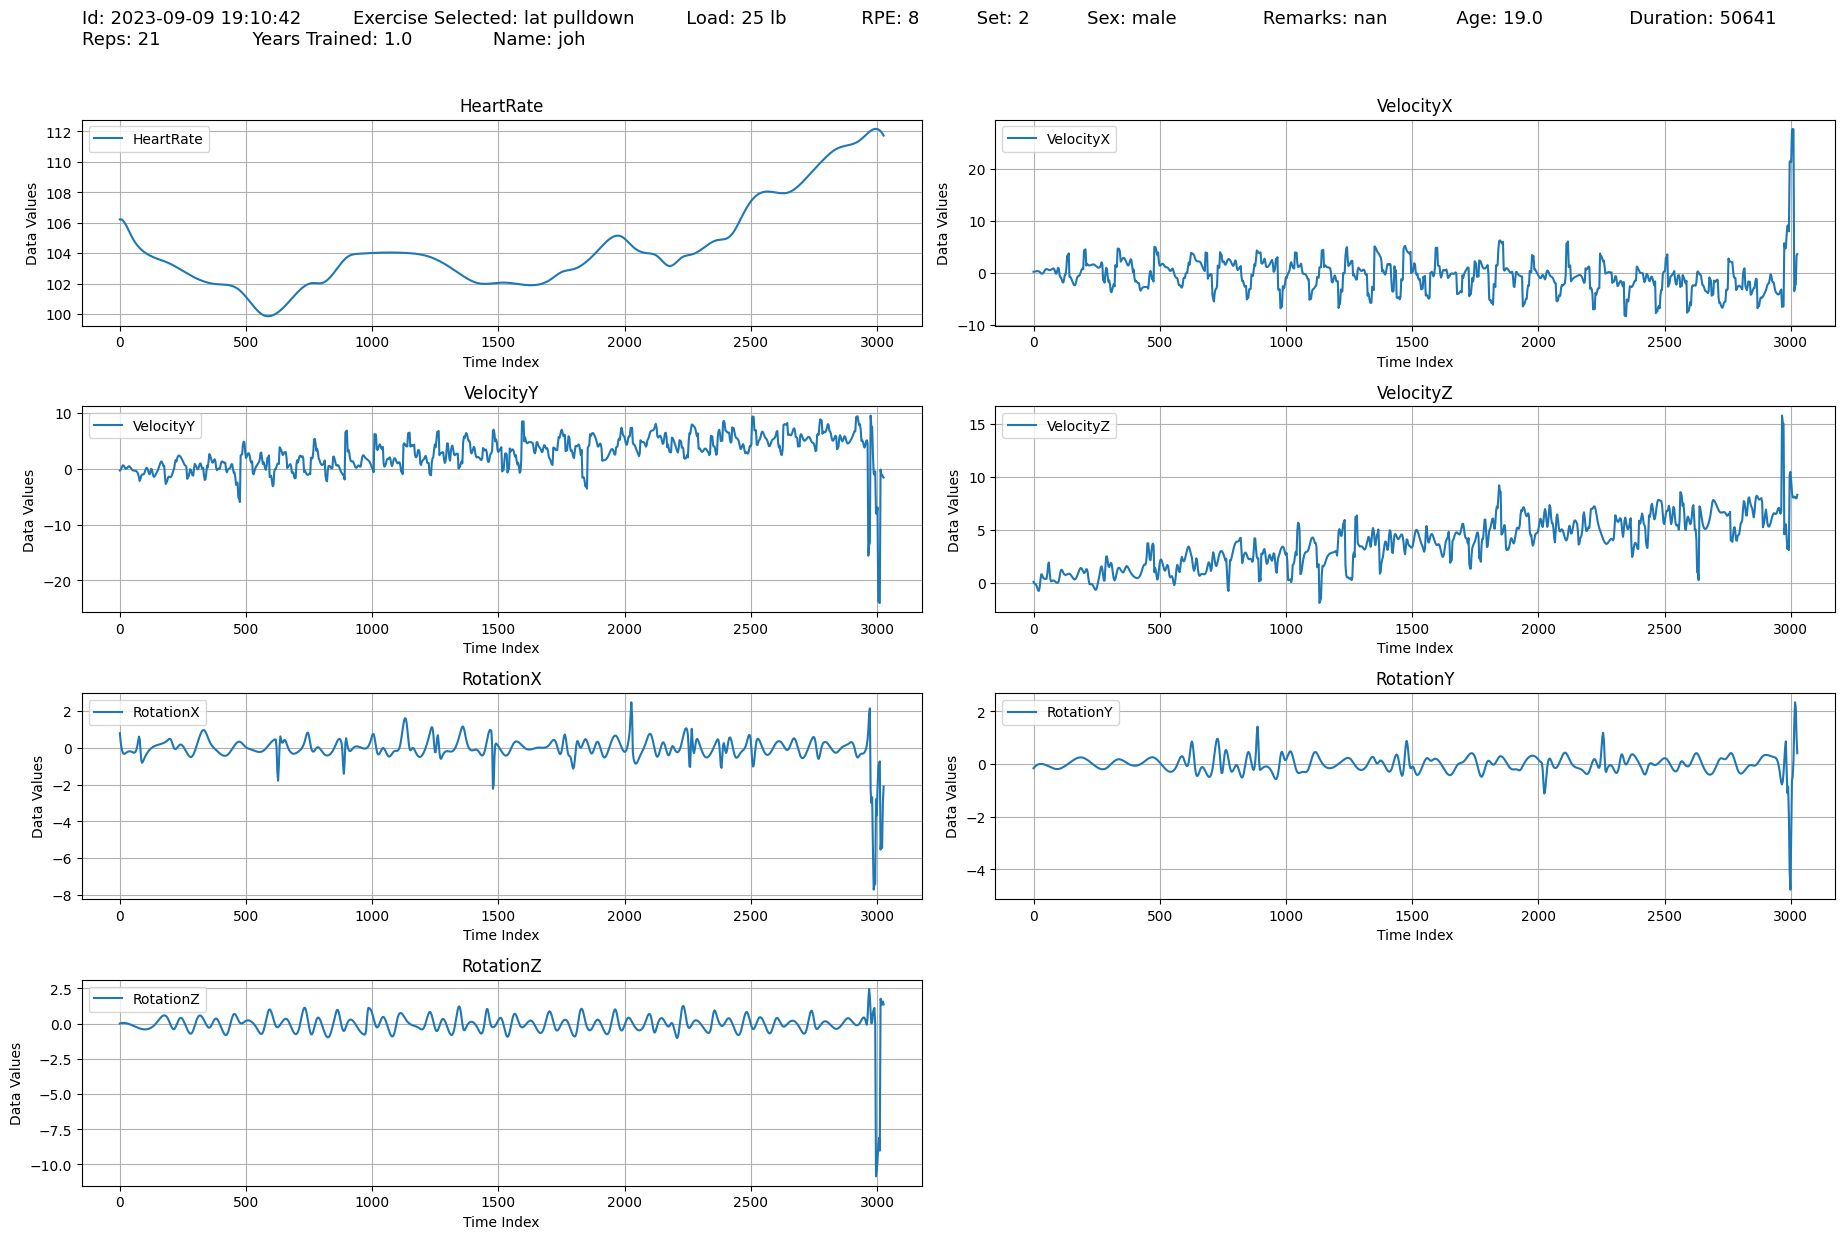

In [25]:
plot_smooth_data(all_data, timestamps, time_series_columns, record_index, 200)

In [26]:
#all_data = all_data.drop(all_data.index[:10])
#all_data.to_csv('all_data.csv', index=False)

In [27]:
#delete_record_and_save_to_csv(all_data, 3, 'all_data.csv')

In [28]:
filtered_df = all_data[all_data['Remarks'].notnull()]

# Display only the "Remarks" column
print(filtered_df['Remarks'])


6                   hello world
7                   hello world
8                    late start
98                       sitted
99                       sitted
100                      sitted
101                       cable
102                       cable
116               improper form
123               improper form
124    improper form at the end
130                 late record
135                   bench 1st
159     change firdt set to 3!4
224           technogym machine
227                    dropset 
246                  cross body
247                       cross
330                   technogym
335                  incomplete
Name: Remarks, dtype: object


In [29]:
print(all_data['Name'].unique())

['kalki' 'lhyn mae' 'jom comedia' 'deuz' 'andreb' 'raha' 't' 'bryan'
 'josh' 'jan' 'a' 'kenn ballesteros' 'rianne alvarez' 'rianne alvarez '
 'kim' 'ronn' 'sean bartolome' 'doreen' 'duwi' 'toreen' 'dui'
 'lou ballesteros' 'lou ballesteros ' 'john' 'joh ']


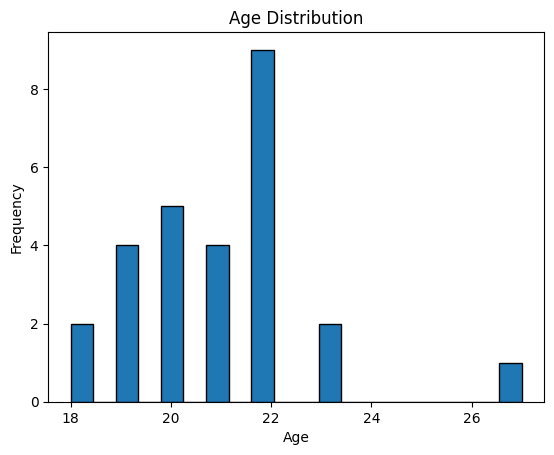

In [30]:
unique_age_df = all_data.drop_duplicates(subset=['Name', 'Age'])

plt.hist(unique_age_df['Age'], bins=20, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

In [31]:
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('squat', 'hammer curl')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('deadlift', 'lat pulldown')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('tricep kickback', 'tricep pushdown')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('lunges', 'chest fly')

In [106]:
all_data.loc[all_data['Name'] == 'kalki', 'Name'] = 'kalki lamadrid'

In [107]:
all_data.to_csv('all_data.csv', index=False)

In [108]:
dfPage = 0

In [109]:
all_data.loc[dfPage*50:(dfPage+1)*50,['Set', 'Name', 'Exercise Selected', 'Load', 'Reps', 'RPE', 'Remarks', 'Duration', 'Id','Years Trained']]

,Set,Name,Exercise Selected,Load,Reps,RPE,Remarks,Duration,Id,Years Trained
0,1,kalki lamadrid,bicep curl,22 kg,12,8.5,NaN,44975,2023-09-01 22:52:03,6.0
1,1,kalki lamadrid,bicep curl,22 kg,12,8.5,NaN,44927,2023-09-01 22:52:27,6.0
2,2,kalki lamadrid,bicep curl,22 kg,12,8.5,NaN,50478,2023-09-01 22:55:47,6.0
3,2,kalki lamadrid,bicep curl,22 kg,12,8.5,NaN,50409,2023-09-01 22:56:05,6.0
4,3,kalki lamadrid,bicep curl,22 kg,10,9.5,NaN,51354,2023-09-01 23:00:52,6.0
5,3,kalki lamadrid,bicep curl,22 kg,10,9.5,NaN,51432,2023-09-01 23:01:17,6.0
6,1,kalki lamadrid,bench press,2 kg,2,7.5,hello world,26314,2023-09-02 06:55:34,6.0
7,1,kalki lamadrid,bench press,5 kg,2,7.5,hello world,26246,2023-09-02 06:55:54,6.0
8,1,lhyn mae,back rows,15 kg,15,7,late start,64628,2023-09-02 07:52:02,1.0
9,3,lhyn mae,back rows,10 kg,12,7,NaN,29080,2023-09-02 08:11:36,1.0
